## **Завантаження даних**

In [5]:
from google.colab import drive
drive.mount("/content/drive", force_remount=True)

Mounted at /content/drive


In [39]:
import os
import re
import pandas as pd
import numpy as np
import seaborn as sns
from os import listdir
from os.path import isfile, join
from sklearn import svm
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, accuracy_score
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
from scipy.stats import zscore

%matplotlib inline
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

In [8]:
# Шлях до папки, де знаходяться папки walking, running, idle, stairs
base_folder = '/content/drive/MyDrive/data'

# Створюємо порожній DataFrame для зберігання даних
all_data = pd.DataFrame()

# Ітеруємося по папкам
for activity_folder in os.listdir(base_folder):
    activity_path = os.path.join(base_folder, activity_folder)
    # Перевіряємо, чи це є папкою
    if os.path.isdir(activity_path):
        # Ітеруємося по файлам у папці
        for file_name in os.listdir(activity_path):
            # Перевіряємо, чи файл має розширення .csv
            if file_name.endswith('.csv'):
                file_path = os.path.join(activity_path, file_name)

                activity_data = pd.read_csv(file_path)
                activity_data['activity'] = activity_folder
                #num=re.match(f'{activity_folder}-(\d+).csv', file_name)
                #activity_data['num']=int(num.group(1))
                all_data = pd.concat([all_data, activity_data], ignore_index=True)

print(type(all_data))

<class 'pandas.core.frame.DataFrame'>


In [9]:
all_data.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity
0,0.138864,4.280833,8.604761,idle
1,-0.071826,4.323929,8.714894,idle
2,0.028730,4.486734,8.939949,idle
3,0.071826,4.343082,8.532935,idle
4,0.052672,4.304775,8.944737,idle


## **Попередня інформація про дані**

In [14]:
activities = listdir(base_folder)
activities

['idle', 'stairs', 'walking', 'running']

In [15]:
for name in activities:
  path = join(base_folder, name)
  frames= listdir(path)
  print(f'{name} = {len(frames)}')

idle = 1039
stairs = 165
walking = 1850
running = 3408


 **Кількість даних по кожному виду діяльності**

In [17]:
class_counts = all_data['activity'].value_counts()
class_counts

running    102240
walking     55500
idle        31170
stairs       4950
Name: activity, dtype: int64

In [18]:
all_data.head()

,accelerometer_X,accelerometer_Y,accelerometer_Z,activity
0,0.138864,4.280833,8.604761,idle
1,-0.071826,4.323929,8.714894,idle
2,0.028730,4.486734,8.939949,idle
3,0.071826,4.343082,8.532935,idle
4,0.052672,4.304775,8.944737,idle


In [19]:
all_data.describe()

,accelerometer_X,accelerometer_Y,accelerometer_Z
count,193860.000000,193860.000000,193860.000000
mean,1.923550,1.598343,1.804896
std,8.404867,12.474041,7.191590
min,-39.188293,-39.188293,-39.188293
25%,-2.494758,-8.327033,-2.494758
50%,0.248997,-0.009577,0.905008
75%,4.668694,8.671799,7.187394
max,39.188293,39.188293,39.188293


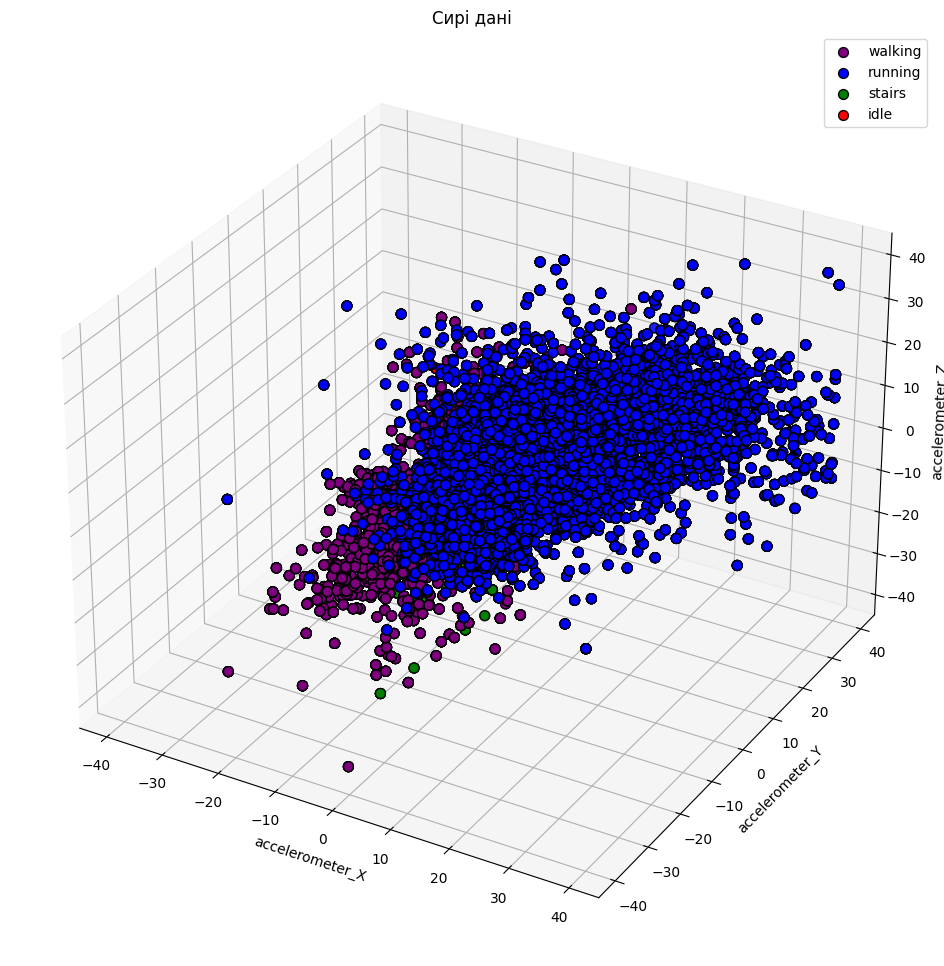

In [37]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

x_values = all_data['accelerometer_X']
y_values = all_data['accelerometer_Y']
z_values = all_data['accelerometer_Z']
activity_labels = all_data['activity']

colors = {'walking': 'purple', 'running': 'blue', 'stairs': 'green', 'idle': 'red'}

for activity, color in colors.items():
    indices = (activity_labels == activity)
    ax.scatter(x_values[indices], y_values[indices], z_values[indices], label=activity, color=color, edgecolors='black', s=50)

ax.set_xlabel('accelerometer_X')
ax.set_ylabel('accelerometer_Y')
ax.set_zlabel('accelerometer_Z')
ax.set_title('Сирі дані')

plt.legend()
plt.show()




## Робота із сирими даними df_raw - це копія all_data

Перші рядки сирого датасету:
   accelerometer_X  accelerometer_Y  accelerometer_Z activity
0         0.138864         4.280833         8.604761     idle
1        -0.071826         4.323929         8.714894     idle
2         0.028730         4.486734         8.939949     idle
3         0.071826         4.343082         8.532935     idle
4         0.052672         4.304775         8.944737     idle
Статистична інформація:
       accelerometer_X  accelerometer_Y  accelerometer_Z
count    193860.000000    193860.000000    193860.000000
mean          1.923550         1.598343         1.804896
std           8.404867        12.474041         7.191590
min         -39.188293       -39.188293       -39.188293
25%          -2.494758        -8.327033        -2.494758
50%           0.248997        -0.009577         0.905008
75%           4.668694         8.671799         7.187394
max          39.188293        39.188293        39.188293


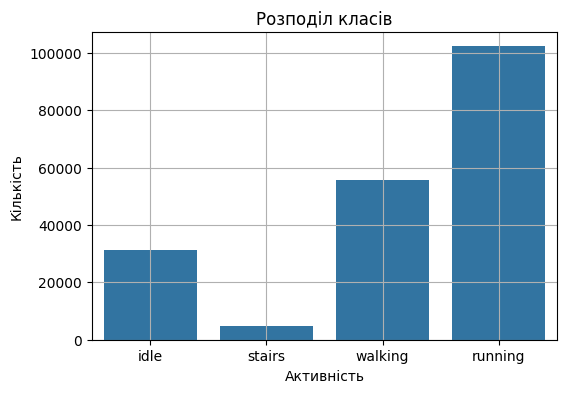

Розподіл класів:
running    102240
walking     55500
idle        31170
stairs       4950
Name: activity, dtype: int64


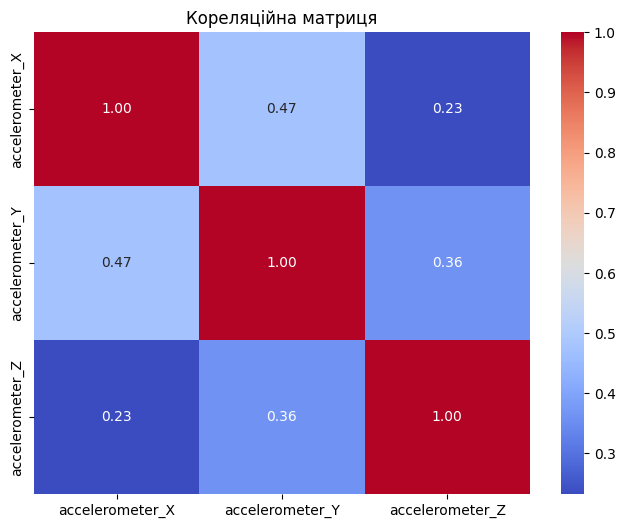

In [29]:
# Копіюємо сирі дані
df_raw = all_data.copy()


print("Перші рядки сирого датасету:")
print(df_raw.head())

print("Статистична інформація:")
print(df_raw.describe())

# Візуалізація розподілу класів
plt.figure(figsize=(6, 4))
sns.countplot(x='activity', data=df_raw)
plt.title('Розподіл класів')
plt.xlabel('Активність')
plt.ylabel('Кількість')
plt.grid()
plt.show()
print("Розподіл класів:")
print(df_raw['activity'].value_counts())
# Візуалізація кореляційної матриці
plt.figure(figsize=(8, 6))
sns.heatmap(df_raw.corr(numeric_only=True), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Кореляційна матриця')
plt.show()


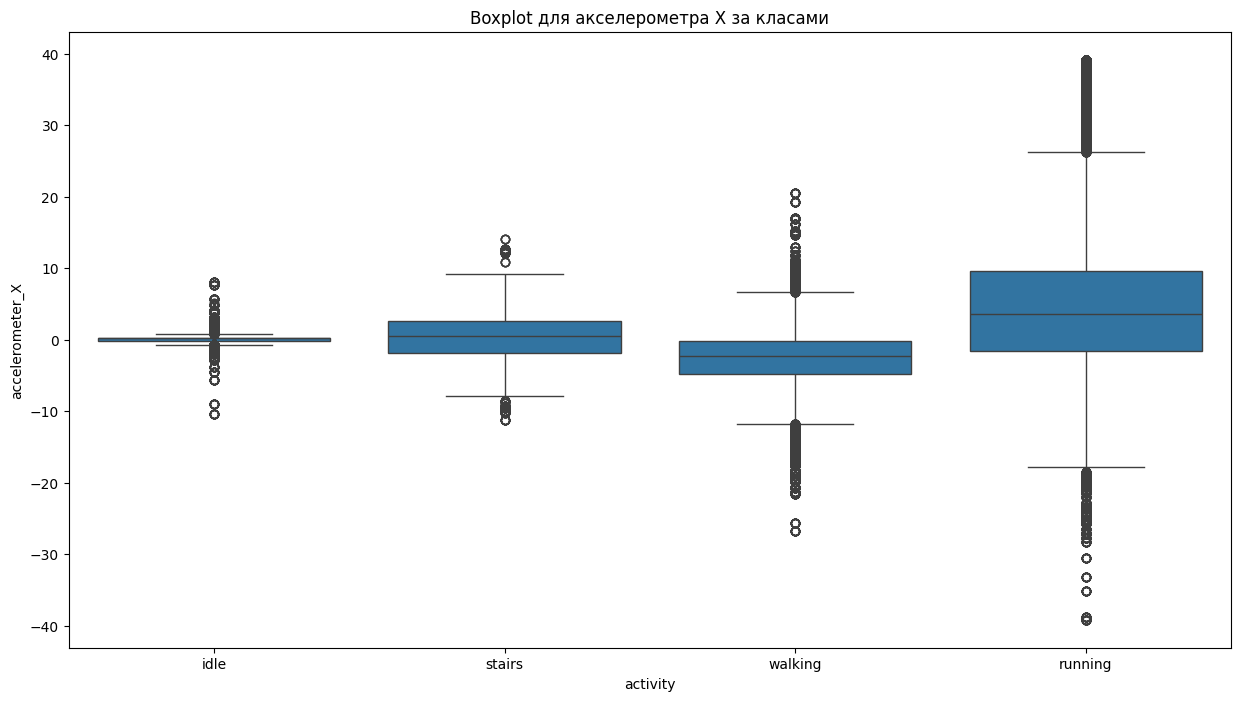

In [30]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='activity', y='accelerometer_X', data=df_raw)
plt.title('Boxplot для акселерометра X за класами')
plt.show()


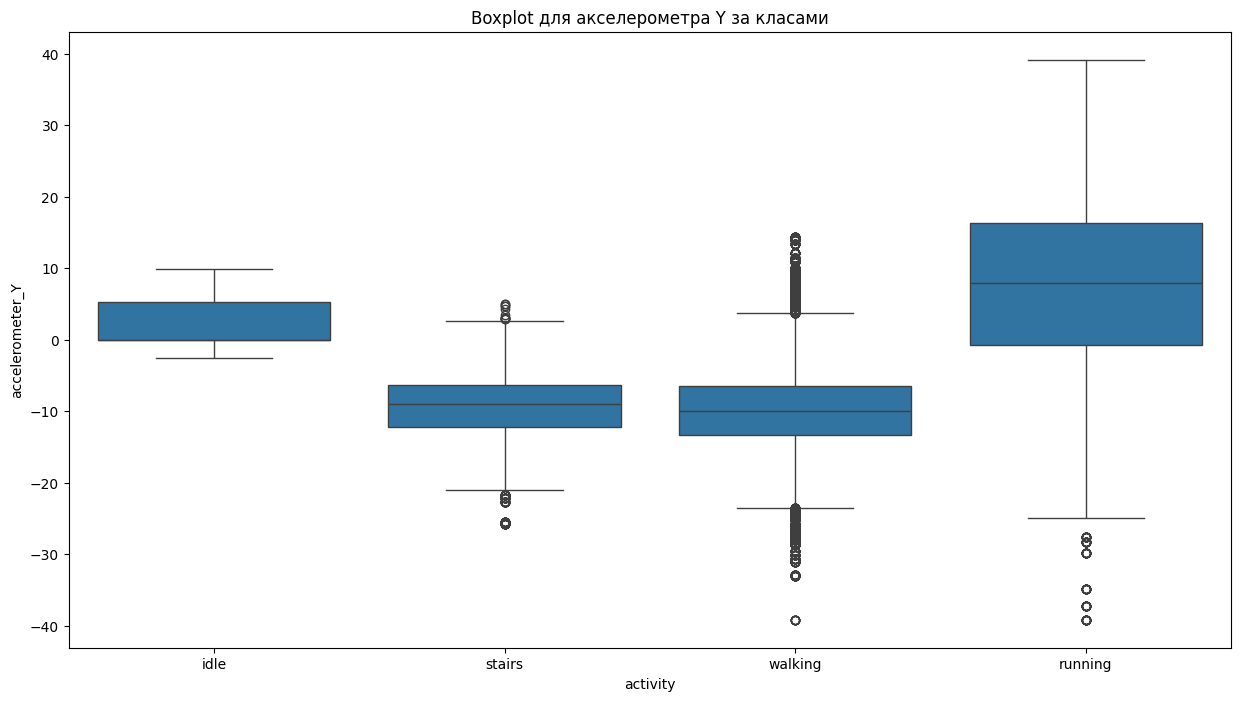

In [31]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='activity', y='accelerometer_Y', data=df_raw)
plt.title('Boxplot для акселерометра Y за класами')
plt.show()

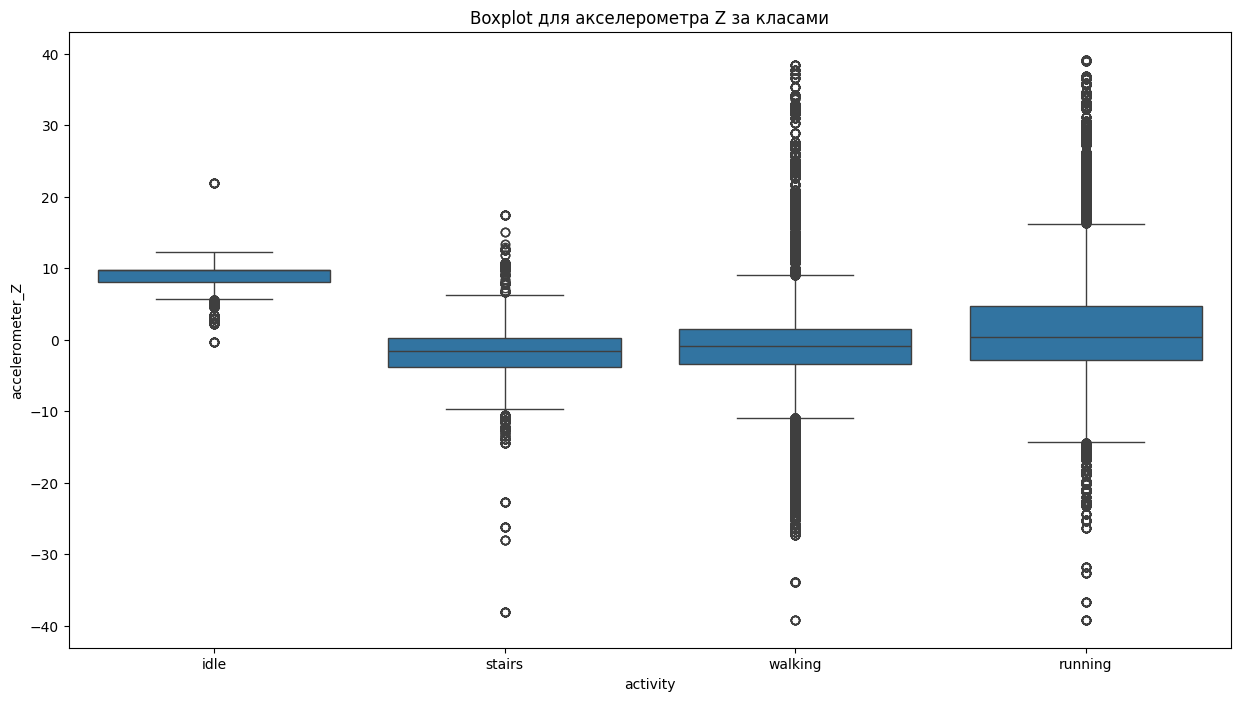

In [32]:
plt.figure(figsize=(15, 8))
sns.boxplot(x='activity', y='accelerometer_Z', data=df_raw)
plt.title('Boxplot для акселерометра Z за класами')
plt.show()

## **Підготовка даних**

## **Очищення даних методами IQR та Z-оцінки**

In [33]:
# Виявлення викидів за допомогою IQR
Q1 = all_data[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']].quantile(0.25)
Q3 = all_data[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']].quantile(0.75)
IQR = Q3 - Q1

# Фільтрація викидів
all_data_no_outliers_iqr = all_data[~((all_data[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']] < (Q1 - 1.5 * IQR)) | (all_data[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']] > (Q3 + 1.5 * IQR))).any(axis=1)]

print("Розмір датасету після обробки викидів за методом IQR:", all_data_no_outliers_iqr.shape)


Розмір датасету після обробки викидів за методом IQR: (173515, 4)


In [34]:
class_counts = all_data_no_outliers_iqr['activity'].value_counts()
print(class_counts)

running    85144
walking    52317
idle       31155
stairs      4899
Name: activity, dtype: int64


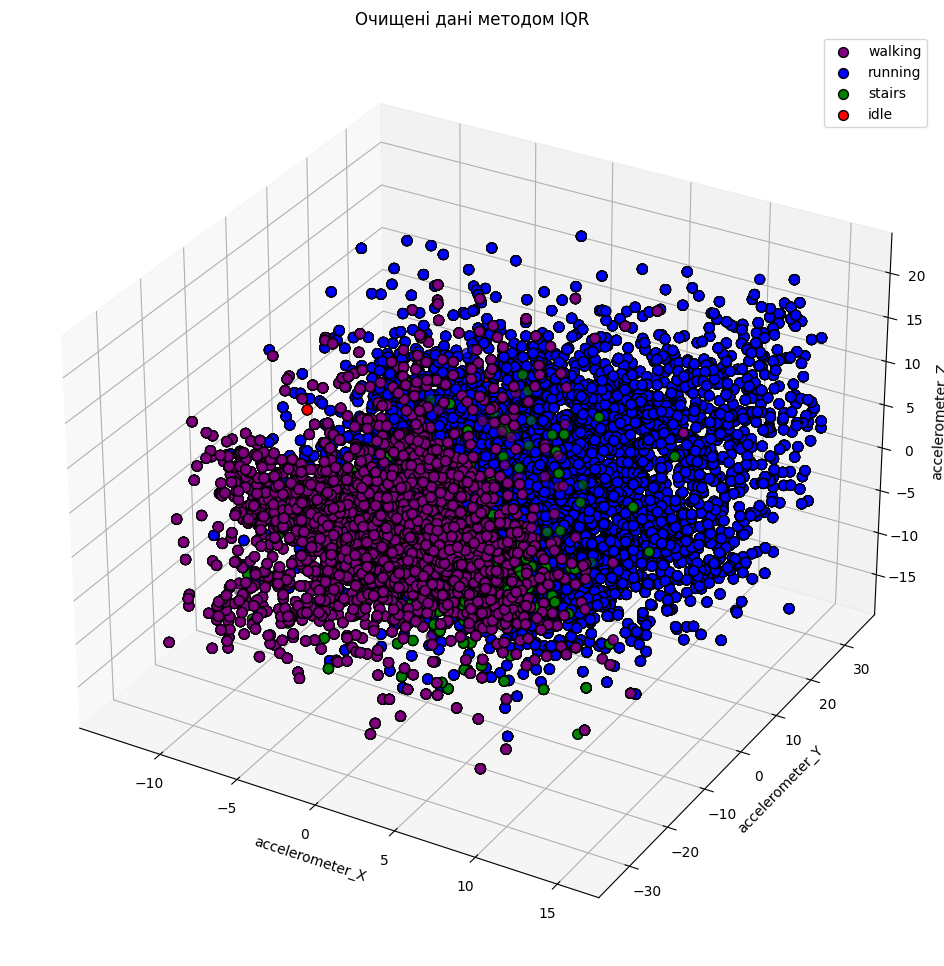

In [35]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

x_values = all_data_no_outliers_iqr['accelerometer_X']
y_values = all_data_no_outliers_iqr['accelerometer_Y']
z_values = all_data_no_outliers_iqr['accelerometer_Z']
activity_labels = all_data_no_outliers_iqr['activity']

colors = {'walking': 'purple', 'running': 'blue', 'stairs': 'green', 'idle': 'red'}

for activity, color in colors.items():
    indices = (activity_labels == activity)
    ax.scatter(x_values[indices], y_values[indices], z_values[indices], label=activity, color=color, edgecolors='black', s=50)

ax.set_xlabel('accelerometer_X')
ax.set_ylabel('accelerometer_Y')
ax.set_zlabel('accelerometer_Z')
ax.set_title('Очищені дані методом IQR')

plt.legend()
plt.show()

In [40]:
# Виявлення викидів за допомогою Z-оцінки
z_scores = np.abs(zscore(all_data[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']]))
all_data_no_outliers_zscore = all_data[(z_scores < 3).all(axis=1)]

print("Розмір датасету після обробки викидів за методом Z-оцінки:", all_data_no_outliers_zscore.shape)


Розмір датасету після обробки викидів за методом Z-оцінки: (187177, 4)


In [41]:
class_counts = all_data_no_outliers_zscore['activity'].value_counts()
print(class_counts)

running    97014
walking    54094
idle       31170
stairs      4899
Name: activity, dtype: int64


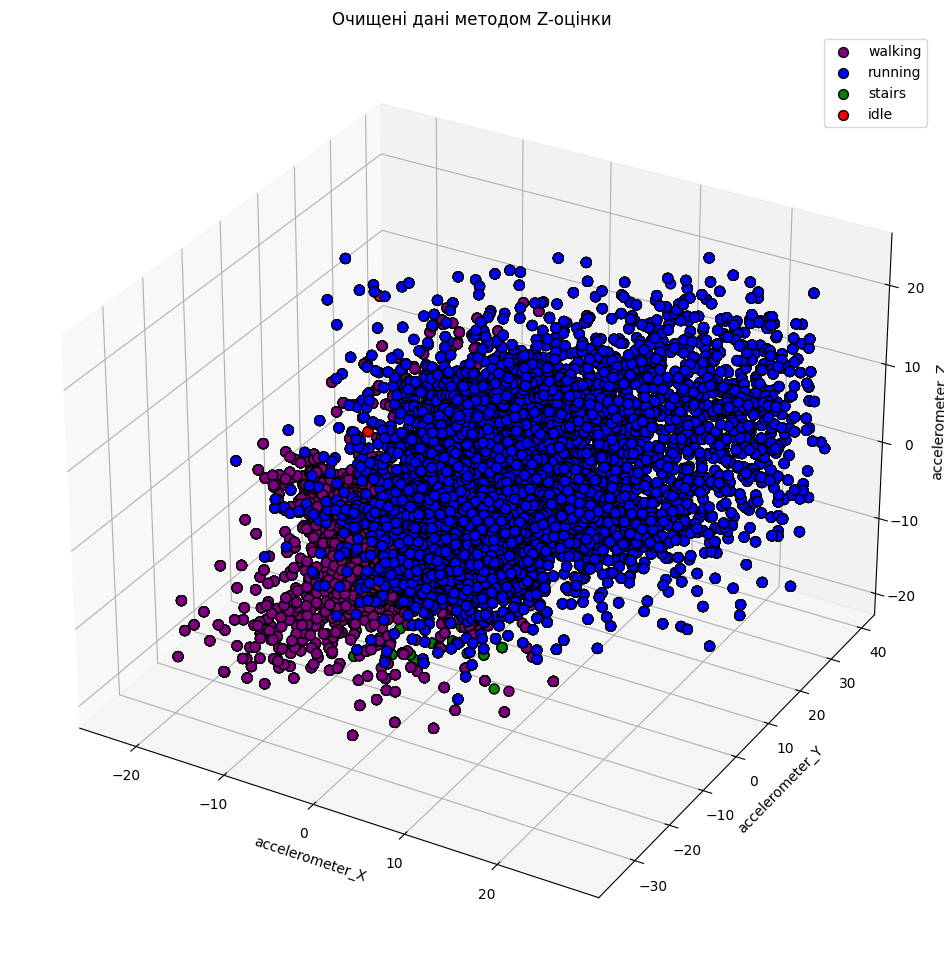

In [43]:
fig = plt.figure(figsize=(15, 12))
ax = fig.add_subplot(111, projection='3d')

x_values = all_data_no_outliers_zscore['accelerometer_X']
y_values = all_data_no_outliers_zscore['accelerometer_Y']
z_values = all_data_no_outliers_zscore['accelerometer_Z']
activity_labels = all_data_no_outliers_zscore['activity']

colors = {'walking': 'purple', 'running': 'blue', 'stairs': 'green', 'idle': 'red'}

for activity, color in colors.items():
    indices = (activity_labels == activity)
    ax.scatter(x_values[indices], y_values[indices], z_values[indices], label=activity, color=color, edgecolors='black', s=50)

ax.set_xlabel('accelerometer_X')
ax.set_ylabel('accelerometer_Y')
ax.set_zlabel('accelerometer_Z')
ax.set_title('Очищені дані методом Z-оцінки')

plt.legend()
plt.show()

## **Створення та тренування моделей без часових ознак**

In [45]:
# Встановлення ваг класів
class_weights = {'idle': 3408 / 1039, 'walking': 3408 / 1850, 'stairs': 3408 / 165, 'running': 1}

# Підготовка даних
X = all_data_no_outliers_iqr[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']]
y = all_data_no_outliers_iqr['activity']

# Розділення на тренувальний та тестовий набори
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



In [46]:
# Створення моделі SVM з вагами класів
svm_model = SVC(class_weight=class_weights)
# Тренування моделі
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f'Accuracy SVM: {accuracy}')
print('Classification Report:\n', report)

Accuracy SVM: 0.7862432642711005
Classification Report:
               precision    recall  f1-score   support

        idle       0.94      0.99      0.97      6144
     running       0.97      0.77      0.86     17092
      stairs       0.11      0.68      0.19       993
     walking       0.87      0.71      0.78     10474

    accuracy                           0.79     34703
   macro avg       0.72      0.79      0.70     34703
weighted avg       0.91      0.79      0.83     34703



In [47]:
# Створення моделі RandomForest з вагами класів
rf_model = RandomForestClassifier(class_weight=class_weights)

# Тренування моделі
rf_model.fit(X_train, y_train)
y_pred = rf_model.predict(X_test)

accuracy_rf = accuracy_score(y_test, y_pred)
report_rf= classification_report(y_test, y_pred)

print(f'Accuracy RFC: {accuracy_rf}')
print('Classification Report:\n', report_rf)

Accuracy RFC: 0.9995965766648417
Classification Report:
               precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6144
     running       1.00      1.00      1.00     17092
      stairs       1.00      0.99      0.99       993
     walking       1.00      1.00      1.00     10474

    accuracy                           1.00     34703
   macro avg       1.00      1.00      1.00     34703
weighted avg       1.00      1.00      1.00     34703



In [48]:
# Встановлення ваг класів
class_weights = {'idle': 3408 / 1039, 'walking': 3408 / 1850, 'stairs': 3408 / 165, 'running': 1}

# Підготовка даних
X_sc = all_data_no_outliers_zscore[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z']]
y_sc = all_data_no_outliers_zscore['activity']

# Розділення на тренувальний та тестовий набори
X_train_sc, X_test_sc, y_train_sc, y_test_sc = train_test_split(X_sc, y_sc, test_size=0.2, random_state=42)


In [49]:
# Створення моделі SVM з вагами класів
svm_model_sc = SVC(class_weight=class_weights)
# Тренування моделі
svm_model_sc.fit(X_train_sc, y_train_sc)

y_pred_sc = svm_model_sc.predict(X_test_sc)

accuracy_sc = accuracy_score(y_test_sc, y_pred_sc)
report_sc = classification_report(y_test_sc, y_pred_sc)

print(f'Accuracy SVM: {accuracy_sc}')
print('Classification Report:\n', report_sc)

Accuracy SVM: 0.795303985468533
Classification Report:
               precision    recall  f1-score   support

        idle       0.94      0.99      0.96      6213
     running       0.98      0.79      0.87     19445
      stairs       0.10      0.65      0.18      1008
     walking       0.87      0.70      0.78     10770

    accuracy                           0.80     37436
   macro avg       0.72      0.78      0.70     37436
weighted avg       0.92      0.80      0.84     37436



In [50]:
# Створення моделі RandomForest з вагами класів
rf_model_sc = RandomForestClassifier(class_weight=class_weights)

# Тренування моделі
rf_model_sc.fit(X_train_sc, y_train_sc)
y_pred_sc = rf_model_sc.predict(X_test_sc)

accuracy_rf_sc = accuracy_score(y_test_sc, y_pred_sc)
report_rf_sc = classification_report(y_test_sc, y_pred_sc)

print(f'Accuracy RFC: {accuracy_rf_sc}')
print('Classification Report:\n', report_rf_sc)

Accuracy RFC: 0.9997595896997542
Classification Report:
               precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6213
     running       1.00      1.00      1.00     19445
      stairs       1.00      1.00      1.00      1008
     walking       1.00      1.00      1.00     10770

    accuracy                           1.00     37436
   macro avg       1.00      1.00      1.00     37436
weighted avg       1.00      1.00      1.00     37436



## **Додавання часових ознак до очищених даних IQR**

In [51]:
# Розрахунок метрик
def calculate_metrics(data, component):
    metrics = {}

    metrics[f'accelerometer_{component}_mean'] = data[f'accelerometer_{component}'].mean()
    metrics[f'accelerometer_{component}_max'] = data[f'accelerometer_{component}'].max()
    metrics[f'accelerometer_{component}_interquartile_range'] = np.percentile(data[f'accelerometer_{component}'], 75) - np.percentile(data[f'accelerometer_{component}'], 25)
    metrics[f'accelerometer_{component}_index_of_minimum_value'] = data[f'accelerometer_{component}'].idxmin()
    metrics[f'accelerometer_{component}_mean_of_absolute_deviation'] = np.mean(np.abs(data[f'accelerometer_{component}'] - data[f'accelerometer_{component}'].mean()))
    metrics[f'accelerometer_{component}_median'] = data[f'accelerometer_{component}'].median()
    metrics[f'accelerometer_{component}_standard_deviation'] = data[f'accelerometer_{component}'].std()
    metrics[f'accelerometer_{component}_root_mean_square_error'] = np.sqrt(np.mean(data[f'accelerometer_{component}'] ** 2))


    return metrics

# Розрахунок метрик для кожної компоненти
metrics_X = calculate_metrics(all_data_no_outliers_iqr, 'X')
metrics_Y = calculate_metrics(all_data_no_outliers_iqr, 'Y')
metrics_Z = calculate_metrics(all_data_no_outliers_iqr, 'Z')

# Додавання розрахованих метрик до датафрейму
all_data_no_outliers_iqr = all_data_no_outliers_iqr.assign(**metrics_X, **metrics_Y, **metrics_Z)

# Виведення результатів
print(all_data_no_outliers_iqr[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z', 'accelerometer_X_mean', 'accelerometer_Y_mean', 'accelerometer_Z_mean']])


        accelerometer_X  accelerometer_Y  accelerometer_Z  \
0              0.138864         4.280833         8.604761   
1             -0.071826         4.323929         8.714894   
2              0.028730         4.486734         8.939949   
3              0.071826         4.343082         8.532935   
4              0.052672         4.304775         8.944737   
...                 ...              ...              ...   
193855        12.919112         6.612785         8.355765   
193856         2.164359         6.962339        13.417107   
193857         4.017470         3.701436         4.951209   
193858        -2.111686         4.807557         7.402872   
193859         4.448427         4.716578        10.831368   

        accelerometer_X_mean  accelerometer_Y_mean  accelerometer_Z_mean  
0                   0.497621              -0.05791              1.560444  
1                   0.497621              -0.05791              1.560444  
2                   0.497621              

In [52]:
# Створення списку із словників метрик для кожної компоненти
metrics_list = [metrics_X, metrics_Y, metrics_Z]

# Цикл для виведення всіх метрик
for component, metrics in zip(['X', 'Y', 'Z'], metrics_list):
    print(f"Metrics for accelerometer_{component}:")
    for metric_name, metric_value in metrics.items():
        print(f"{metric_name}: {metric_value}")
    print("\n")


Metrics for accelerometer_X:
accelerometer_X_mean: 0.49762056450450975
accelerometer_X_max: 15.413871
accelerometer_X_interquartile_range: 5.813121000000001
accelerometer_X_index_of_minimum_value: 140818
accelerometer_X_mean_of_absolute_deviation: 3.825327544222237
accelerometer_X_median: 0.158017
accelerometer_X_standard_deviation: 5.144727051563313
accelerometer_X_root_mean_square_error: 5.168722290850182


Metrics for accelerometer_Y:
accelerometer_Y_mean: -0.05791040714635593
accelerometer_Y_max: 34.10301
accelerometer_Y_interquartile_range: 15.509640000000001
accelerometer_Y_index_of_minimum_value: 83459
accelerometer_Y_mean_of_absolute_deviation: 8.681611444666363
accelerometer_Y_median: -0.0478839999999999
accelerometer_Y_standard_deviation: 10.736086601661915
accelerometer_Y_root_mean_square_error: 10.736211848124642


Metrics for accelerometer_Z:
accelerometer_Z_mean: 1.5604439274414317
accelerometer_Z_max: 21.648373
accelerometer_Z_interquartile_range: 9.141062
accelerometer_

## **Додавання часових ознак до очищених даних Z-score**

In [53]:
# Розрахунок метрик
def calculate_metrics(data, component):
    metrics = {}

    metrics[f'accelerometer_{component}_mean'] = data[f'accelerometer_{component}'].mean()
    metrics[f'accelerometer_{component}_max'] = data[f'accelerometer_{component}'].max()
    metrics[f'accelerometer_{component}_interquartile_range'] = np.percentile(data[f'accelerometer_{component}'], 75) - np.percentile(data[f'accelerometer_{component}'], 25)
    metrics[f'accelerometer_{component}_index_of_minimum_value'] = data[f'accelerometer_{component}'].idxmin()
    metrics[f'accelerometer_{component}_mean_of_absolute_deviation'] = np.mean(np.abs(data[f'accelerometer_{component}'] - data[f'accelerometer_{component}'].mean()))
    metrics[f'accelerometer_{component}_median'] = data[f'accelerometer_{component}'].median()
    metrics[f'accelerometer_{component}_standard_deviation'] = data[f'accelerometer_{component}'].std()
    metrics[f'accelerometer_{component}_root_mean_square_error'] = np.sqrt(np.mean(data[f'accelerometer_{component}'] ** 2))


    return metrics


# Розрахунок метрик для кожної компоненти
metrics_X = calculate_metrics(all_data_no_outliers_zscore, 'X')
metrics_Y = calculate_metrics(all_data_no_outliers_zscore, 'Y')
metrics_Z = calculate_metrics(all_data_no_outliers_zscore, 'Z')

# Додавання розрахованих метрик до датафрейму
all_data_no_outliers_zscore = all_data_no_outliers_zscore.assign(**metrics_X, **metrics_Y, **metrics_Z)

# Виведення результатів
print(all_data_no_outliers_zscore[['accelerometer_X', 'accelerometer_Y', 'accelerometer_Z', 'accelerometer_X_mean', 'accelerometer_Y_mean', 'accelerometer_Z_mean']])

        accelerometer_X  accelerometer_Y  accelerometer_Z  \
0              0.138864         4.280833         8.604761   
1             -0.071826         4.323929         8.714894   
2              0.028730         4.486734         8.939949   
3              0.071826         4.343082         8.532935   
4              0.052672         4.304775         8.944737   
...                 ...              ...              ...   
193855        12.919112         6.612785         8.355765   
193856         2.164359         6.962339        13.417107   
193857         4.017470         3.701436         4.951209   
193858        -2.111686         4.807557         7.402872   
193859         4.448427         4.716578        10.831368   

        accelerometer_X_mean  accelerometer_Y_mean  accelerometer_Z_mean  
0                    1.39219               1.05292              1.630496  
1                    1.39219               1.05292              1.630496  
2                    1.39219              

## **Навчання моделі IQR**

In [54]:
# Розділимо дані на фічі та цільову змінну
X_iqr = all_data_no_outliers_iqr.drop(columns=['activity'])
y_iqr = all_data_no_outliers_iqr['activity']

# Розділимо дані на тренувальний та тестовий набори
X_train_iqr, X_test_iqr, y_train_iqr, y_test_iqr = train_test_split(X_iqr, y_iqr, test_size=0.2, random_state=42)

# Ініціалізуємо модель
model_iqr = RandomForestClassifier(random_state=42)

# Навчання моделі
model_iqr.fit(X_train_iqr, y_train_iqr)

# Прогнозування на тестових даних
y_pred_iqr = model_iqr.predict(X_test_iqr)

# Оцінка результатів
accuracy_iqr = accuracy_score(y_test_iqr, y_pred_iqr)
classification_rep_iqr = classification_report(y_test_iqr, y_pred_iqr)

# Виведення результатів
print(f"Accuracy: {accuracy_iqr}")
print("Classification Report:\n", classification_rep_iqr)


Accuracy: 0.9995965766648417
Classification Report:
               precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6144
     running       1.00      1.00      1.00     17092
      stairs       1.00      0.99      0.99       993
     walking       1.00      1.00      1.00     10474

    accuracy                           1.00     34703
   macro avg       1.00      1.00      1.00     34703
weighted avg       1.00      1.00      1.00     34703



## **Начання моделі Z-score**

In [55]:
X_sc_clean = all_data_no_outliers_zscore.drop(columns=['activity'])
y_sc_clean = all_data_no_outliers_zscore['activity']


X_train_sc_clean, X_test_sc_clean, y_train_sc_clean, y_test_sc_clean = train_test_split(X_sc_clean, y_sc_clean, test_size=0.2, random_state=42)


model_sc_clean = RandomForestClassifier(random_state=42)


model_sc_clean.fit(X_train_sc_clean, y_train_sc_clean)


y_pred_sc_clean = model_sc_clean.predict(X_test_sc_clean)


accuracy_sc_clean = accuracy_score(y_test_sc_clean, y_pred_sc_clean)
classification_rep_sc_clean = classification_report(y_test_sc_clean, y_pred_sc_clean)

# Виведення результатів
print(f"Accuracy: {accuracy_sc_clean}")
print("Classification Report:\n", classification_rep_sc_clean)

Accuracy: 0.9996527406774228
Classification Report:
               precision    recall  f1-score   support

        idle       1.00      1.00      1.00      6213
     running       1.00      1.00      1.00     19445
      stairs       1.00      0.99      1.00      1008
     walking       1.00      1.00      1.00     10770

    accuracy                           1.00     37436
   macro avg       1.00      1.00      1.00     37436
weighted avg       1.00      1.00      1.00     37436

